# Anomaly Detection API Tutorial
This is a tutorial on how to use the anomaly detection API for data in the MODIS fixed tool. This API was created to help idenitify anomalous data that could be introduced by automation that adds new sites to the fixed site tool. 

The API is available at https://anomaly-detection.ornl.gov

## Making requests
The API accpets GET requests and returns back a JSON message with data for the anoamlies.

In [1]:
# example
import requests

site = "us_california_tonzi_ranch"
# site here is the SITE ID found in the fixed sites tool.
product = "MOD13Q1"
# product is a product available through the fixed sites tool.
# Check the documenation for all available products https://modis.ornl.gov/documentation.html
band = "250m_16_days_EVI"
# band is any band of the given product that has summary data/ subset statisitcs.

url = f"https://anomaly-detection.ornl.gov/anomalies/api/v1/site/{site}/product/{product}/band/{band}"
result = requests.get(url)



## Showing the results

In [4]:
import json
import pandas as pd
print(json.dumps(result.json(),indent=4))


{
    "dates": [
        "2001-09-14",
        "2005-02-02",
        "2005-02-18",
        "2005-03-06",
        "2005-12-19",
        "2010-05-25",
        "2011-10-16",
        "2013-06-26",
        "2013-07-12",
        "2019-06-26",
        "2021-08-13"
    ],
    "values": [
        0.2323,
        0.4257,
        0.4376,
        0.4454,
        0.1344,
        0.3348,
        0.2555,
        0.1969,
        0.1927,
        0.2505,
        0.2326
    ],
    "site": "us_california_tonzi_ranch",
    "product": "MOD13Q1",
    "band": "250m_16_days_EVI"
}


In [5]:
# Organize for plot later
anomaly_df = pd.DataFrame(result.json()) 
anomaly_df = anomaly_df.drop(labels=["site","product","band"], axis=1)
anomaly_df = anomaly_df.rename({"dates":"calendar_dates"}, axis=1) 
anomaly_df = anomaly_df.set_index("calendar_dates")
anomaly_df

,values
calendar_dates,
2001-09-14,0.2323
2005-02-02,0.4257
2005-02-18,0.4376
2005-03-06,0.4454
2005-12-19,0.1344
2010-05-25,0.3348
2011-10-16,0.2555
2013-06-26,0.1969
2013-07-12,0.1927


In [6]:
#Get data to plot 
import requests
import pandas as pd
dates_url = f"https://modis.ornl.gov/rst/api/v1/{product}/{site}/dates"
dates_response = requests.get(dates_url)
dates = dates_response.json().get("dates")
start_date = dates[0].get("modis_date")
end_date = dates[-1].get("modis_date")

subset_url = f"https://modis.ornl.gov/rst/api/v1/{product}/{site}/subsetStatistics?band={band}&startDate={start_date}&endDate={end_date}"
subset_response = requests.get(subset_url)
subset_json = subset_response.json()
subset_json = subset_json["statistics"]

stats = pd.read_json(json.dumps(subset_json))
stats.set_index("calendar_date", inplace=True)
stats.index = pd.to_datetime(stats.index)

calendar_dates = stats.index.strftime("%Y-%m-%d").tolist()
means = stats["value_mean"]
data = {"calendar_dates": calendar_dates, "value_means": means}
data_df = pd.DataFrame(data)
data_df = data_df.drop(columns=["calendar_dates"])
data_df


,value_means
calendar_date,
2000-02-18,0.3293
2000-03-05,0.3585
2000-03-21,0.3817
2000-04-06,0.3758
2000-04-22,0.3436
...,...
2023-03-22,0.3310
2023-04-07,0.3604
2023-04-23,0.3796


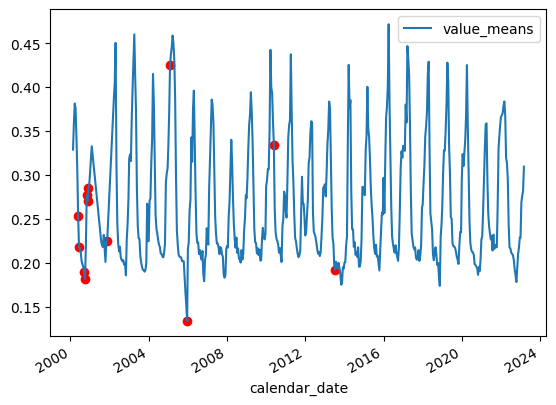

In [45]:
#Plotting data and possible anomalies
%matplotlib inline
ax = data_df.plot()
ax.scatter(x=anomaly_df.index,y=anomaly_df["values"],c="red")

## How does this work?
The data used by the API comes from the MODIS REST API.
This data is coming from the `/subsetStatistics` endpoint from the REST API.
Interested in the value_means for the site, product, and band combination across all dates.
Try to use the seasonality of the data. API finds the finds amount of points in period.
API bins the data across the periods. i.e if the period is 4 and there are 12 data points the mapping will look like this.
```
[{date1:value1},{date2:value2},{date3:value3},{date4:value4},
 {date5:value5},{date6:value6},{date7:value7},{date8:value8},
 {date9:value9},{date10:value10},{date11:value11},{date12:value12}]

{0:[value1,value5,value9],
 1:[value2,value6,value10],
 2:[value3,value7,value11],
 3:[value4,value8,value12]}
```
After the values have been binned each value is examined. 
each value is compared against the average of the values in their bin exculding that value. 

i.e for value1 
value1 will be compared against the average of value5 and value9
The comparision uses the mean and standarad deviation to determine if the value is anoamlus. By default the API checks to see if the test value is within 3 standard deviations from the mean, if the test value outside of the this range it it considered to anomalus.

